# NBA Player Acquisition Recommendations 

### Goal
To identify the three best player fits for each team. 

### Data
- https://www.basketball-reference.com/

### Process
1. Establish baseline of successful teams by analyzing regular season stats of the eight teams that advanced to the second round of the post season from each year of the Steph Curry Era (starting with the '14-'15 season).
    - Create vector by z-score of stats within their years over all teams (scaling) 
    - Train binary classification algorithm (KNN/LR/RF) on previous years, with second round playoff teams as positive class.
    - Use algorithm to classify current teams as either successful (comparable to second round teams of past) or unsuccessful
    - Generate recommendations for 'Unsuccessful' teams
  
2. Determine current ('21-'22) team needs by comparing each team with the baseline mentioned above using either Euclidean or Cosine distance, or a combination of both.
3. Determine player strengths and weaknesses by cluster players into archetypes
4. Present 3 player recommendations to each team based on team needs and player strengths

### Table of Contents
0. #### [Data](#data)
    - [Data Scraping](#scrape)
    - [Data Cleaning](#clean)
1. #### [EDA](#eda)
    - [Plot 1a: Avg Shots Made and Attempted by Year](#plt1)
        - [Plot 1b: Shot Accuracy by Year](#plt1b)
        - [Plot 1c: Average Point per Game by Year](#plt1c)
    - [Plot 2: Rebound Averages by Year](#plt2)
    - [Plot 3: Assist, Steal, and Block Averages](#plt3)
    - [Playoff vs. Non-Playoff Regular Season Stats](#pvnp)
    - [2nd Round Teams vs. Non-2nd Round Teams](#2rd)
2. #### [Classification of Current Teams](#class)
    - [Feature Selection](#select)
    - [Train/Test Data](#split)
    - [Model Training](#train)
    - [Model Evaluation](#eval)
    - [Model Optimization](#opt)
    - [Predictions](#pred)

### Libraries

In [222]:
from urllib.request import urlopen
import requests
import pandas as pd
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score, roc_auc_score

# 0. Data <a id='data'></a>

### Data Scraping <a id='scrape'></a>
Scraping method from: https://medium.com/analytics-vidhya/web-scraping-nba-data-with-pandas-beautifulsoup-and-regex-pt-1-e3d73679950a

In [3]:
base_url = 'https://www.basketball-reference.com/leagues/NBA_{}.html'
seasons = ['2015', '2016', '2017', '2018', '2019', '2020', '2021']

In [4]:
def get_info(string_year):
    # Get data and specific table fomr website
    url = base_url.format(string_year)
    data = requests.get(url).text 
    soup = BeautifulSoup(data, 'html.parser')
    team_stats = soup.find('table', id='per_game-team')
    
    # inserting data into dataframe
    stats = []
    for row in team_stats.find_all('tr')[1:]:
        team = dict()
        team['Year'] = string_year
        team['Rank'] = row.find('th', {'data-stat': "ranker"}).text
        team['Name'] = row.find('td', {'data-stat':'team'}).text
        team['Games Played'] = float(row.find('td', {'data-stat':'g'}).text)
        team['Minutes Played'] = float(row.find('td', {'data-stat':'mp'}).text)
        team['FG'] = float(row.find('td', {'data-stat':'fg'}).text)
        team['FGA'] = float(row.find('td', {'data-stat':'fga'}).text)
        team['FG%'] = float(row.find('td', {'data-stat':'fg_pct'}).text)
        team['3P'] = float(row.find('td', {'data-stat':'fg3'}).text)
        team['3PA'] = float(row.find('td', {'data-stat':'fg3a'}).text)
        team['3P%'] = float(row.find('td', {'data-stat':'fg3_pct'}).text)
        team['2P'] = float(row.find('td', {'data-stat':'fg2'}).text)
        team['2PA'] = float(row.find('td', {'data-stat':'fg2a'}).text)
        team['2P%'] = float(row.find('td', {'data-stat':'fg2_pct'}).text)
        team['FT'] = float(row.find('td', {'data-stat':'ft'}).text)
        team['FTA'] = float(row.find('td', {'data-stat':'fta'}).text)
        team['FT%'] = float(row.find('td', {'data-stat':'ft_pct'}).text)
        team['ORB'] = float(row.find('td', {'data-stat':'orb'}).text)
        team['DRB'] = float(row.find('td', {'data-stat':'drb'}).text)
        team['TRB'] = float(row.find('td', {'data-stat':'trb'}).text)
        team['AST'] = float(row.find('td', {'data-stat':'ast'}).text)
        team['STL'] = float(row.find('td', {'data-stat':'stl'}).text)
        team['BLK'] = float(row.find('td', {'data-stat':'blk'}).text)
        team['TOV'] = float(row.find('td', {'data-stat':'tov'}).text)
        team['P Fouls'] = float(row.find('td', {'data-stat':'pf'}).text)
        team['PTS'] = float(row.find('td', {'data-stat':'pts'}).text)
        stats.append(team)
    
    return stats

In [5]:
stats_15 = pd.DataFrame(get_info('2015'))
stats_16 = pd.DataFrame(get_info('2016'))
stats_17 = pd.DataFrame(get_info('2017'))
stats_18 = pd.DataFrame(get_info('2018'))
stats_19 = pd.DataFrame(get_info('2019'))
stats_20 = pd.DataFrame(get_info('2020'))
stats_21 = pd.DataFrame(get_info('2021'))

In [6]:
stats_df = pd.concat([stats_15, stats_16, stats_17, stats_18, stats_19, stats_20, stats_21], axis=0)
stats_df

,Year,Rank,Name,Games Played,Minutes Played,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,P Fouls,PTS
0,2015,1,Golden State Warriors*,82.0,240.6,41.6,87.0,0.478,10.8,27.0,...,0.768,10.4,34.3,44.7,27.4,9.3,6.0,14.5,19.9,110.0
1,2015,2,Los Angeles Clippers*,82.0,240.6,39.4,83.3,0.473,10.1,26.9,...,0.710,9.6,33.1,42.6,24.8,7.8,5.0,12.3,21.3,106.7
2,2015,3,Dallas Mavericks*,82.0,242.4,39.7,85.8,0.463,8.9,25.4,...,0.752,10.5,31.8,42.3,22.5,8.1,4.5,13.0,20.0,105.2
3,2015,4,Oklahoma City Thunder,82.0,241.8,38.8,86.8,0.447,7.7,22.7,...,0.754,12.8,34.7,47.5,20.5,7.3,5.5,14.7,22.3,104.0
4,2015,5,Toronto Raptors*,82.0,242.1,37.9,83.3,0.455,8.9,25.1,...,0.787,10.7,30.8,41.5,20.7,7.5,4.4,12.9,20.9,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,2021,27,Detroit Pistons,72.0,242.1,38.7,85.6,0.452,11.6,32.9,...,0.759,9.6,33.1,42.7,24.2,7.4,5.2,14.9,20.5,106.6
27,2021,28,Oklahoma City Thunder,72.0,241.0,38.8,88.0,0.441,11.9,35.1,...,0.725,9.9,35.7,45.6,22.1,7.0,4.4,16.1,18.1,105.0
28,2021,29,Orlando Magic,72.0,240.7,38.3,89.2,0.429,10.9,31.8,...,0.775,10.4,35.1,45.4,21.8,6.9,4.4,12.8,17.2,104.0
29,2021,30,Cleveland Cavaliers,72.0,242.1,38.6,85.8,0.450,10.0,29.7,...,0.743,10.4,32.3,42.8,23.8,7.8,4.5,15.5,18.2,103.8


### Data Cleaning <a id='clean'></a>

In [7]:
stats_df

,Year,Rank,Name,Games Played,Minutes Played,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,P Fouls,PTS
0,2015,1,Golden State Warriors*,82.0,240.6,41.6,87.0,0.478,10.8,27.0,...,0.768,10.4,34.3,44.7,27.4,9.3,6.0,14.5,19.9,110.0
1,2015,2,Los Angeles Clippers*,82.0,240.6,39.4,83.3,0.473,10.1,26.9,...,0.710,9.6,33.1,42.6,24.8,7.8,5.0,12.3,21.3,106.7
2,2015,3,Dallas Mavericks*,82.0,242.4,39.7,85.8,0.463,8.9,25.4,...,0.752,10.5,31.8,42.3,22.5,8.1,4.5,13.0,20.0,105.2
3,2015,4,Oklahoma City Thunder,82.0,241.8,38.8,86.8,0.447,7.7,22.7,...,0.754,12.8,34.7,47.5,20.5,7.3,5.5,14.7,22.3,104.0
4,2015,5,Toronto Raptors*,82.0,242.1,37.9,83.3,0.455,8.9,25.1,...,0.787,10.7,30.8,41.5,20.7,7.5,4.4,12.9,20.9,104.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26,2021,27,Detroit Pistons,72.0,242.1,38.7,85.6,0.452,11.6,32.9,...,0.759,9.6,33.1,42.7,24.2,7.4,5.2,14.9,20.5,106.6
27,2021,28,Oklahoma City Thunder,72.0,241.0,38.8,88.0,0.441,11.9,35.1,...,0.725,9.9,35.7,45.6,22.1,7.0,4.4,16.1,18.1,105.0
28,2021,29,Orlando Magic,72.0,240.7,38.3,89.2,0.429,10.9,31.8,...,0.775,10.4,35.1,45.4,21.8,6.9,4.4,12.8,17.2,104.0
29,2021,30,Cleveland Cavaliers,72.0,242.1,38.6,85.8,0.450,10.0,29.7,...,0.743,10.4,32.3,42.8,23.8,7.8,4.5,15.5,18.2,103.8


In [8]:
stats_df.isna().sum()

Year              0
Rank              0
Name              0
Games Played      0
Minutes Played    0
FG                0
FGA               0
FG%               0
3P                0
3PA               0
3P%               0
2P                0
2PA               0
2P%               0
FT                0
FTA               0
FT%               0
ORB               0
DRB               0
TRB               0
AST               0
STL               0
BLK               0
TOV               0
P Fouls           0
PTS               0
dtype: int64

In [9]:
stats_df.describe()

,Games Played,Minutes Played,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,P Fouls,PTS
count,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,...,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000,217.000000
mean,78.944700,241.646083,39.646544,86.578341,0.457871,10.393548,29.034101,0.357171,29.253917,57.542396,...,0.766530,10.202765,33.849309,44.050691,23.418433,7.691705,4.858525,14.206452,20.170968,107.083410
std,5.007095,0.802828,2.007417,2.874189,0.015024,2.295841,5.972029,0.016718,2.028568,4.827300,...,0.029954,1.033061,1.708804,1.925105,2.208177,0.814012,0.714100,1.139954,1.427065,5.881807
min,64.000000,240.000000,33.700000,77.200000,0.408000,5.000000,14.900000,0.317000,23.100000,41.900000,...,0.668000,7.900000,29.300000,38.600000,18.000000,5.700000,2.400000,11.100000,16.600000,91.900000
25%,73.000000,241.000000,38.300000,84.500000,0.448000,8.800000,24.800000,0.347000,27.800000,54.700000,...,0.748000,9.500000,32.800000,42.800000,21.700000,7.100000,4.300000,13.400000,19.100000,102.900000
50%,82.000000,241.600000,39.500000,86.800000,0.458000,10.300000,29.100000,0.355000,29.300000,57.400000,...,0.771000,10.200000,33.900000,44.000000,23.400000,7.700000,4.800000,14.100000,20.200000,106.600000
75%,82.000000,242.100000,41.200000,88.500000,0.468000,12.000000,33.300000,0.369000,30.800000,61.200000,...,0.787000,10.800000,35.000000,45.200000,24.800000,8.200000,5.300000,14.900000,21.200000,111.800000
max,82.000000,244.000000,44.700000,94.000000,0.503000,16.700000,45.400000,0.416000,33.400000,68.300000,...,0.839000,13.100000,42.200000,51.700000,30.400000,10.000000,7.500000,17.700000,24.800000,120.100000


# 1. EDA <a id='eda'></a >
- [Plot 1a: Average Shots Made and Attempted by Year](#plt1) 
    - [Plot 1b: Shot Accuracy by Year](#plt1b) 
    - [Plot 1c: Average Point per Game by Year](#plt1c)
- [Plot 2: Rebound Averages by Year](#plt2) 
- [Plot 3: Assist, Steal, and Block Averages](#plt3)
- [Playoff vs. Non-Playoff Regular Season Stats](#pvnp)

In [10]:
by_year = stats_df.groupby(by='Year').mean()
by_year

,Games Played,Minutes Played,FG,FGA,FG%,3P,3PA,3P%,2P,2PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,P Fouls,PTS
Year,,,,,,,,,,,,,,,,,,,,,
2015,82.000000,241.929032,37.516129,83.564516,0.449000,7.848387,22.409677,0.349129,29.674194,61.161290,...,0.750645,10.877419,32.406452,43.306452,22.022581,7.729032,4.793548,14.354839,20.219355,100.016129
2016,82.000000,241.787097,38.229032,84.570968,0.452194,8.506452,24.083871,0.352806,29.719355,60.493548,...,0.757935,10.425806,33.341935,43.751613,22.287097,7.838710,4.951613,14.390323,20.258065,102.664516
2017,82.000000,241.600000,39.048387,85.416129,0.457194,9.651613,27.003226,0.357194,29.390323,58.409677,...,0.771806,10.132258,33.377419,43.519355,22.625806,7.709677,4.738710,13.961290,19.893548,105.590323
2018,82.000000,241.383871,39.606452,86.064516,0.460258,10.487097,28.996774,0.361742,29.122581,57.051613,...,0.767484,9.716129,33.806452,43.516129,23.238710,7.712903,4.803226,14.270968,19.858065,106.335484
2019,82.000000,241.622581,41.074194,89.212903,0.460484,11.361290,32.006452,0.355484,29.716129,57.203226,...,0.766935,10.345161,34.822581,45.170968,24.580645,7.622581,4.948387,14.077419,20.903226,111.203226
2020,70.612903,241.780645,40.832258,88.803226,0.459903,12.193548,34.103226,0.357774,28.629032,54.709677,...,0.772258,10.096774,34.719355,44.790323,24.367742,7.651613,4.893548,14.564516,20.780645,111.687097
2021,72.000000,241.419355,41.219355,88.416129,0.466065,12.706452,34.635484,0.366065,28.525806,53.767742,...,0.778645,9.825806,34.470968,44.300000,24.806452,7.577419,4.880645,13.825806,19.283871,112.087097


### Plot 1a: Average Shots Made and Attemped by Year <a id='plt1'></a> 

Difference in FG made: 9.87%
Difference in FG attempted: 5.81%
---
Difference in 2P made: -3.87%
Difference in 2P attempted: -12.09%
---
Difference in 3P made: 61.9%
Difference in 3P attempted: 54.56%


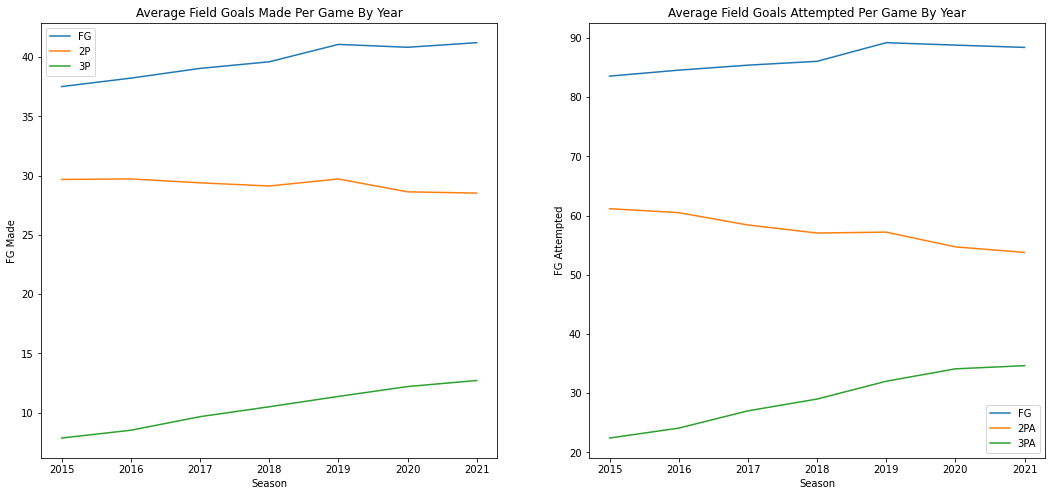

In [11]:
fig, axs = plt.subplots(1,2, figsize=(18,8))

axs[0].plot(by_year.index, by_year['FG'], label='FG')
axs[0].plot(by_year.index, by_year['2P'], label='2P')
axs[0].plot(by_year.index, by_year['3P'], label='3P')
axs[0].set_title('Average Field Goals Made Per Game By Year')
axs[0].set(xlabel='Season', ylabel='FG Made')
axs[0].legend()

axs[1].plot(by_year.index, by_year['FGA'], label='FG')
axs[1].plot(by_year.index, by_year['2PA'], label='2PA')
axs[1].plot(by_year.index, by_year['3PA'], label='3PA')
axs[1].set_title('Average Field Goals Attempted Per Game By Year')
axs[1].set(xlabel='Season', ylabel='FG Attempted')
axs[1].legend()

diff_fg = (by_year.iloc[-1]['FG'] - by_year.iloc[0]['FG'])/by_year.iloc[0]['FG']
diff_fga = (by_year.iloc[-1]['FGA'] - by_year.iloc[0]['FGA'])/by_year.iloc[0]['FGA']
diff_2p = (by_year.iloc[-1]['2P'] - by_year.iloc[0]['2P'])/by_year.iloc[0]['2P']
diff_2pa = (by_year.iloc[-1]['2PA'] - by_year.iloc[0]['2PA'])/by_year.iloc[0]['2PA']
diff_3p = (by_year.iloc[-1]['3P'] - by_year.iloc[0]['3P'])/by_year.iloc[0]['3P']
diff_3pa = (by_year.iloc[-1]['3PA'] - by_year.iloc[0]['3PA'])/by_year.iloc[0]['3PA']

print('Difference in FG made: {}%'.format(round(diff_fg*100, 2)))
print('Difference in FG attempted: {}%'.format(round(diff_fga*100, 2)))
print('---')
print('Difference in 2P made: {}%'.format(round(diff_2p*100, 2)))
print('Difference in 2P attempted: {}%'.format(round(diff_2pa*100, 2)))
print('---')
print('Difference in 3P made: {}%'.format(round(diff_3p*100, 2)))
print('Difference in 3P attempted: {}%'.format(round(diff_3pa*100, 2)))

**Findings**<br>

From the 2015 season to the 2021 season, field goal makes and attempts increased by 9.87% and 5.81% respeectively. This increase in shooting volume implies an increase in the pace of the game. The increase in total shot volume can be attributed entirely to the increase of 3 point shot volume, as 2 point shot volume actually decreases over time. Three point makes and attempts increase at a very high rate, 61.9% and 54.56% resepectively. This shows the impact that Steph Curry has on the game. Two point shots made and attempts both decrease, -3.87% and -12.09% resepectively. 


### Plot 1b: Shot Accuracy by Year <a id='plt1b'></a>

Difference in FG%: 1.706%
Difference in 2p%: 4.484%
Difference in 3p%: 1.694%


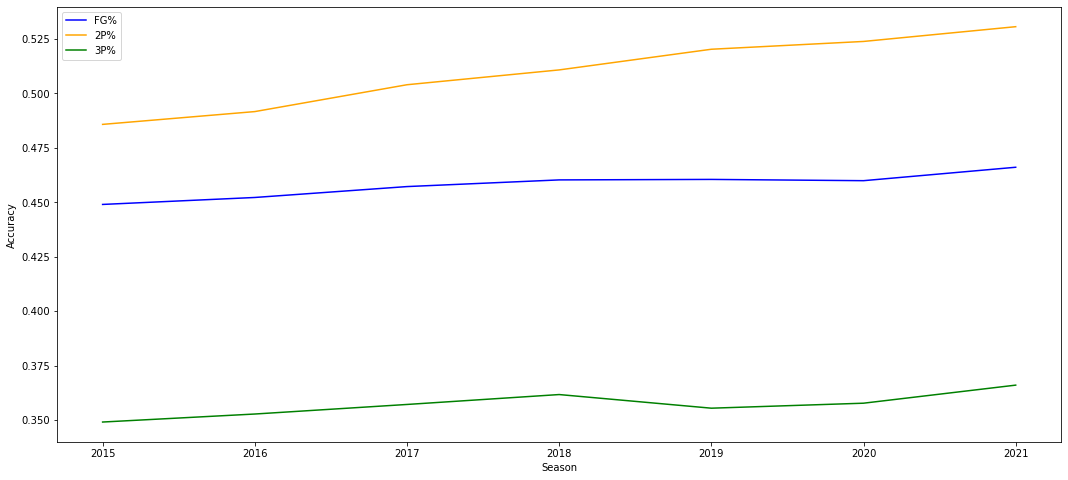

In [12]:
#fig, axs = plt.subplots(1,3, figsize=(18,8))
plt.figure(figsize=(18,8))
plt.plot(by_year.index, by_year['FG%'], color='blue', label='FG%')
plt.plot(by_year.index, by_year['2P%'], color='orange', label='2P%')
plt.plot(by_year.index, by_year['3P%'], color='green', label='3P%')
plt.xlabel('Season')
plt.ylabel('Accuracy')
plt.legend()

diff_fgp = by_year.iloc[-1]['FG%'] - by_year.iloc[0]['FG%']
diff_2pp = by_year.iloc[-1]['2P%'] - by_year.iloc[0]['2P%']
diff_3pp = by_year.iloc[-1]['3P%'] - by_year.iloc[0]['3P%']

print('Difference in FG%: {}%'.format(round(diff_fgp*100, 3)))
print('Difference in 2p%: {}%'.format(round(diff_2pp*100, 3)))
print('Difference in 3p%: {}%'.format(round(diff_3pp*100, 3)))

### Plot 1c: Average Points Per Game by Year <a id='plt1c'></a>

Difference in points: 12.07%


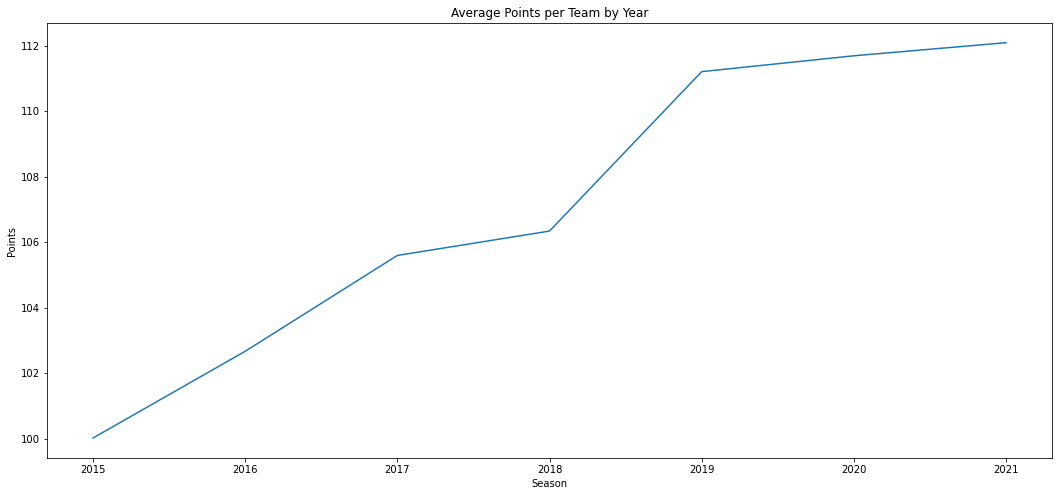

In [13]:
plt.figure(figsize=(18,8))
plt.plot(by_year.index, by_year['PTS'])
plt.title('Average Points per Team by Year')
plt.xlabel('Season')
plt.ylabel('Points')

diff_pts = (by_year.iloc[-1]['PTS'] - by_year.iloc[0]['PTS'])/by_year.iloc[0]['PTS']
print('Difference in points: {}%'.format(round(diff_pts*100, 2)))

### Plot 2: Rebound Averages by Year <a id='plt2'></a>

Difference in TRB: 2.294%
Difference in DRB: 6.371%
Difference in ORB: -9.668%


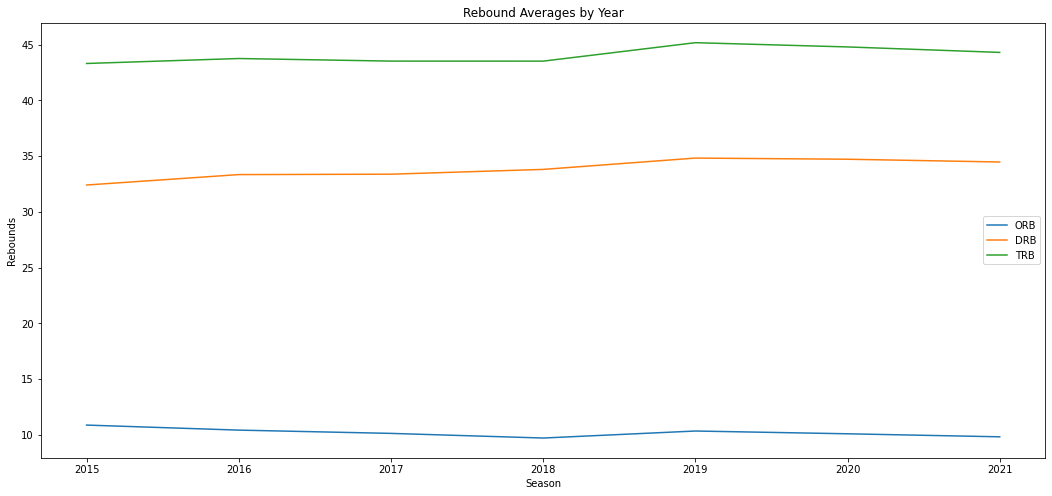

In [14]:
plt.figure(figsize=(18,8))
plt.plot(by_year.index, by_year['ORB'], label='ORB')
plt.plot(by_year.index, by_year['DRB'], label='DRB')
plt.plot(by_year.index, by_year['TRB'], label='TRB')
plt.title('Rebound Averages by Year')
plt.xlabel('Season')
plt.ylabel('Rebounds')
plt.legend()

diff_trb = (by_year.iloc[-1]['TRB'] - by_year.iloc[0]['TRB'])/by_year.iloc[0]['TRB']
diff_drb = (by_year.iloc[-1]['DRB'] - by_year.iloc[0]['DRB'])/by_year.iloc[0]['DRB']
diff_orb = (by_year.iloc[-1]['ORB'] - by_year.iloc[0]['ORB'])/by_year.iloc[0]['ORB']

print('Difference in TRB: {}%'.format(round(diff_trb*100, 3)))
print('Difference in DRB: {}%'.format(round(diff_drb*100, 3)))
print('Difference in ORB: {}%'.format(round(diff_orb*100, 3)))

### Plot 3: Assist, Steal, Block Averages <a id='plt3'></a>

Difference in AST: 12.64%
Difference in STL: -1.96%
Difference in BLK: 1.82%


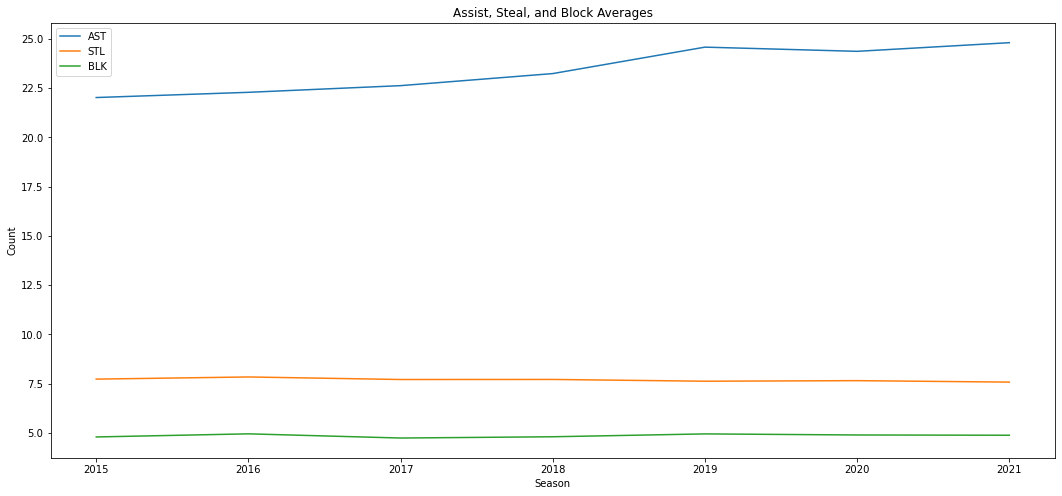

In [15]:
plt.figure(figsize=(18,8))
plt.plot(by_year.index, by_year['AST'], label='AST')
plt.plot(by_year.index, by_year['STL'], label='STL')
plt.plot(by_year.index, by_year['BLK'], label='BLK')
plt.title('Assist, Steal, and Block Averages')
plt.xlabel('Season')
plt.ylabel('Count')
plt.legend()

diff_ast = (by_year.iloc[-1]['AST'] - by_year.iloc[0]['AST'])/by_year.iloc[0]['AST']
diff_stl = (by_year.iloc[-1]['STL'] - by_year.iloc[0]['STL'])/by_year.iloc[0]['STL']
diff_blk = (by_year.iloc[-1]['BLK'] - by_year.iloc[0]['BLK'])/by_year.iloc[0]['BLK']

print('Difference in AST: {}%'.format(round(diff_ast*100, 2)))
print('Difference in STL: {}%'.format(round(diff_stl*100, 2)))
print('Difference in BLK: {}%'.format(round(diff_blk*100, 2)))

### Playoff vs. Non-Playoff Teams <a id='pvnp'></a>

In [16]:
po = []
not_po = []
for row in range(len(stats_df)):
    if '*' in stats_df.iloc[row]['Name']:
        po.append(stats_df.iloc[row])
    elif stats_df.iloc[row]['Name'] != 'League Average':
        not_po.append(stats_df.iloc[row])
        
po_df = pd.DataFrame(po)
np_df = pd.DataFrame(not_po)

In [17]:
po_df

,Year,Rank,Name,Games Played,Minutes Played,FG,FGA,FG%,3P,3PA,...,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,P Fouls,PTS
0,2015,1,Golden State Warriors*,82.0,240.6,41.6,87.0,0.478,10.8,27.0,...,0.768,10.4,34.3,44.7,27.4,9.3,6.0,14.5,19.9,110.0
1,2015,2,Los Angeles Clippers*,82.0,240.6,39.4,83.3,0.473,10.1,26.9,...,0.710,9.6,33.1,42.6,24.8,7.8,5.0,12.3,21.3,106.7
2,2015,3,Dallas Mavericks*,82.0,242.4,39.7,85.8,0.463,8.9,25.4,...,0.752,10.5,31.8,42.3,22.5,8.1,4.5,13.0,20.0,105.2
4,2015,5,Toronto Raptors*,82.0,242.1,37.9,83.3,0.455,8.9,25.1,...,0.787,10.7,30.8,41.5,20.7,7.5,4.4,12.9,20.9,104.0
5,2015,6,Houston Rockets*,82.0,241.5,37.0,83.3,0.444,11.4,32.7,...,0.715,11.7,32.0,43.7,22.2,9.5,5.0,16.7,22.0,103.9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15,2021,16,Boston Celtics*,72.0,241.4,41.5,88.9,0.466,13.6,36.4,...,0.775,10.6,33.6,44.3,23.5,7.7,5.3,14.1,20.4,112.6
16,2021,17,Dallas Mavericks*,72.0,240.3,41.1,87.3,0.470,13.8,38.1,...,0.778,9.1,34.2,43.3,22.9,6.3,4.3,12.1,19.4,112.4
21,2021,22,Los Angeles Lakers*,72.0,242.4,40.6,86.1,0.472,11.1,31.2,...,0.739,9.7,34.6,44.2,24.7,7.8,5.4,15.2,19.1,109.5
24,2021,25,Miami Heat*,72.0,241.4,39.2,83.7,0.468,12.9,36.2,...,0.790,8.0,33.5,41.5,26.3,7.9,4.0,14.1,18.9,108.1


In [18]:
diffs = po_df.mean()[4:] - np_df.mean()[4:]

In [23]:
diffs.sort_values(ascending=False)

PTS        3.509311
3PA        1.537500
DRB        0.998852
FG         0.982908
3P         0.967092
TRB        0.835077
AST        0.671939
FT         0.565051
FTA        0.370791
BLK        0.273469
STL        0.184694
2P         0.024362
2P%        0.017712
3P%        0.014367
FT%        0.013626
FG%        0.013477
ORB       -0.158291
P Fouls   -0.311735
FGA       -0.373980
TOV       -0.554719
2PA       -1.920791
dtype: float64

Positive: Playoff Team stats are higher
Negative: Playoff Team stats are lower


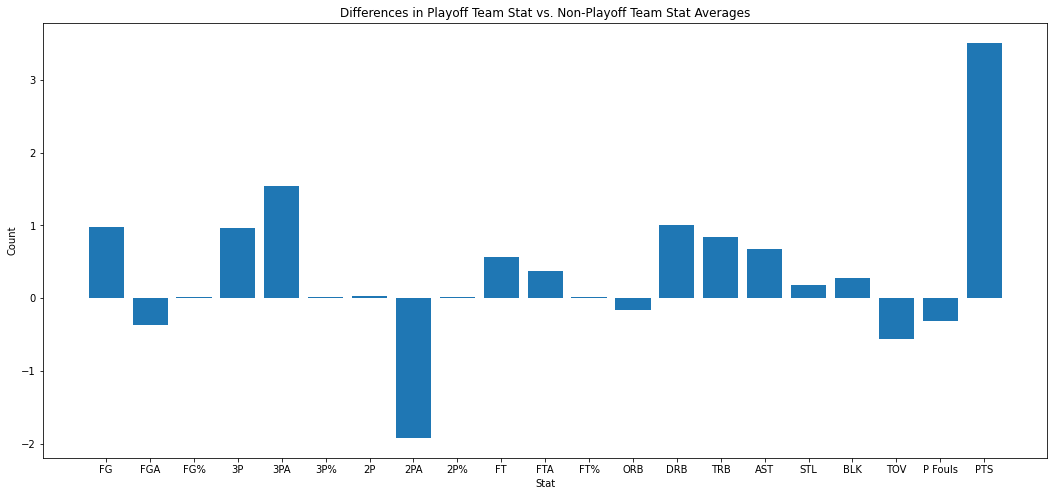

In [22]:
plt.figure(figsize=(18,8))
plt.bar(diffs.index, diffs.values)
plt.title('Differences in Playoff Team Stat vs. Non-Playoff Team Stat Averages')
plt.xlabel('Stat')
plt.ylabel('Count')

print('Positive: Playoff Team stats are higher')
print('Negative: Playoff Team stats are lower')

**Findings**
<br>

Field Goal Statistics: 
<br>
Playoff teams average ~0.37 less field goal attempts per game than non-playoff teams. However, playoff teams average ~1 more field goal make per game. This implies that playoff teams are more selective with their shots than non-playoff teams and wait for better looks, which results in more makes. 

Two-point Statistics: 
<br>
The two point statistics echo a similar sentiments as the field goal statistics, reinforcing shot selectivity as an important aspect of the game. 

Three-point Statistics: 
<br>
The three point shot statistics are interesting in that playoff teams only shoot ~1.4% better than non-playoff teams. However playoff teams average ~2 more three point attempts and ~1 more three point makes, indicating that volume of threes is more important than three accuracy. 

Free Throw Statistics:
<br>
Playoff teams were able to get ~0.37 more free throw attempts per game than non-playoff teams, indicating that they are better at getting to the line. Playoff teams also made ~0.57 more free throws per game.

Rebounding Statistics: 
<br>
- DRB/TRB: Playoff teams were able to grab ~1 more defensive rebound than non-playoff teams. Defensive rebounds are important because they indicate a certain number of advantageous possession changes.  
- ORB: Playoff teams grabbed ~0.15 less offensive rebounds than non-playoff teams, which could be a result of playoff teams making more of their shots, resulting in less offensive rebound opportunities. 

Assists, Steals, and Blocks:
- AST: Playoff teams averaged ~0.67 more assist per game than non-playoff teams. This indicates more team integration.
- STL and BLK: Playoff teams averaged ~0.18 more steals and ~0.27 more blocks implying more aggressive defense.

TOVs and Fouls:
- TOV: Playoff teams averaged ~0.55 less TOVs than non-playoff teams showing that they are more careful with the ball.
- Fouls: Playoff teams averaged ~0.31 less personal fouls than non-playoff teams. This coupled with more aggressive defense shows that playoff teams are smart about their defense. 


# 2nd Round Teams vs. Non-2nd Round Teams <a id='2rd'></a>

In [54]:
rd2_lst = []
not_rd2_lst = []

po_15 = ['Atlanta Hawks*', 'Washington Wizards*', 'Cleveland Cavaliers*', 'Chicago Bulls*', 
         'Golden State Warriors*', 'Memphis Grizzlies*', 'Houston Rockets*', 'Los Angeles Clippers*']
po_16 = ['Cleveland Cavaliers*', 'Atlanta Hawks*', 'Toronto Raptors*', 'Miami Heat*', 
         'Golden State Warriors*', 'Portland Trail Blazers*', 'Oklahoma City Thunder*', 'San Antonio Spurs*']
po_17 = ['Boston Celtics*', 'Washington Wizards*', 'Cleveland Cavaliers*', 'Toronto Raptors*', 
         'Golden State Warriors*', 'Utah Jazz*', 'San Antonio Spurs*', 'Houston Rockets*']
po_18 = ['Boston Celtics*', 'Philadelphia 76ers*', 'Cleveland Cavaliers*', 'Toronto Raptors*', 
         'Golden State Warriors*', 'New Orleans Pelicans*', 'Houston Rockets*', 'Utah Jazz*']
po_19 = ['Milwaukee Bucks*', 'Boston Celtics*', 'Toronto Raptors*', 'Philadelphia 76ers*', 
         'Golden State Warriors*', 'Houston Rockets*', 'Portland Trail Blazers*', 'Denver Nuggets*']
po_20 = ['Boston Celtics*', 'Toronto Raptors*', 'Miami Heat*', 'Milwaukee Bucks*', 
         'Denver Nuggets*', 'Los Angeles Clippers*', 'Los Angeles Lakers*', 'Houston Rockets*']
po_21 = ['Atlanta Hawks*', 'Philadelphia 76ers*', 'Milwaukee Bucks*', 'Brooklyn Nets*', 
         'Los Angeles Clippers*', 'Utah Jazz*', 'Phoenix Suns*', 'Denver Nuggets*']

In [50]:
for row in range(len(stats_df)):
    record = stats_df.iloc[row]
    if record['Year'] == '2015' and record['Name'] in po_15:
        rd2_lst.append(record)
    elif record['Year'] == '2016' and record['Name'] in po_16:
        rd2_lst.append(record)
    elif record['Year'] == '2017' and record['Name'] in po_17:
        rd2_lst.append(record)
    elif record['Year'] == '2018' and record['Name'] in po_18:
        rd2_lst.append(record)
    elif record['Year'] == '2019' and record['Name'] in po_19:
        rd2_lst.append(record)
    elif record['Year'] == '2020' and record['Name'] in po_20:
        rd2_lst.append(record)
    elif record['Year'] == '2021' and record['Name'] in po_21:
        rd2_lst.append(record)
    elif record['Name'] != 'League Average': 
        not_rd2_lst.append(record)

In [53]:
rd2 = pd.DataFrame(rd2_lst)
not_rd2 = pd.DataFrame(not_rd2_lst)

In [58]:
diff_2 = rd2.mean()[4:] - not_rd2.mean()[4:]
diff_2

FG         1.224513
FGA       -0.332955
FG%        0.015857
3P         1.448214
3PA        2.695130
3P%        0.016058
2P        -0.224351
2PA       -3.030357
2P%        0.023763
FT         0.508117
FTA        0.186039
FT%        0.016135
ORB       -0.221266
DRB        1.238312
TRB        1.017208
AST        1.355357
STL        0.219805
BLK        0.415097
TOV       -0.091234
P Fouls   -0.268994
PTS        4.389448
dtype: float64

Positive: 2nd Round Team stats are higher
Negative: 2nd Round Team stats are lower


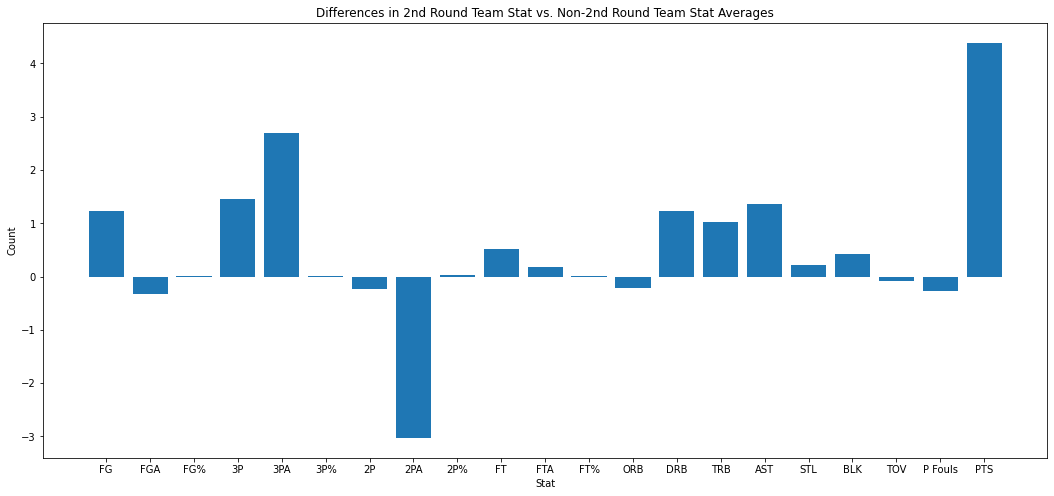

In [60]:
plt.figure(figsize=(18,8))
plt.bar(diff_2.index, diff_2.values)
plt.title('Differences in 2nd Round Team Stat vs. Non-2nd Round Team Stat Averages')
plt.xlabel('Stat')
plt.ylabel('Count')

print('Positive: 2nd Round Team stats are higher')
print('Negative: 2nd Round Team stats are lower')

In [62]:
print(diffs)
print(diff_2)

FG         0.982908
FGA       -0.373980
FG%        0.013477
3P         0.967092
3PA        1.537500
3P%        0.014367
2P         0.024362
2PA       -1.920791
2P%        0.017712
FT         0.565051
FTA        0.370791
FT%        0.013626
ORB       -0.158291
DRB        0.998852
TRB        0.835077
AST        0.671939
STL        0.184694
BLK        0.273469
TOV       -0.554719
P Fouls   -0.311735
PTS        3.509311
dtype: float64
FG         1.224513
FGA       -0.332955
FG%        0.015857
3P         1.448214
3PA        2.695130
3P%        0.016058
2P        -0.224351
2PA       -3.030357
2P%        0.023763
FT         0.508117
FTA        0.186039
FT%        0.016135
ORB       -0.221266
DRB        1.238312
TRB        1.017208
AST        1.355357
STL        0.219805
BLK        0.415097
TOV       -0.091234
P Fouls   -0.268994
PTS        4.389448
dtype: float64


# 2. Classification <a id='class'></a>

### Feature Selection <a id='select'></a>

In [197]:
stats = stats_df[stats_df['Name']!='League Average']

In [198]:
rd2_col = []
for row in range(len(stats_dropped)):
    record = stats_dropped.iloc[row]
    if record['Year'] == '2015' and record['Name'] in po_15:
        rd2_col.append(1)
    elif record['Year'] == '2016' and record['Name'] in po_16:
        rd2_col.append(1)
    elif record['Year'] == '2017' and record['Name'] in po_17:
        rd2_col.append(1)
    elif record['Year'] == '2018' and record['Name'] in po_18:
        rd2_col.append(1)
    elif record['Year'] == '2019' and record['Name'] in po_19:
        rd2_col.append(1)
    elif record['Year'] == '2020' and record['Name'] in po_20:
        rd2_col.append(1)
    elif record['Year'] == '2021' and record['Name'] in po_21:
        rd2_col.append(1)
    else: 
        rd2_col.append(0)

In [199]:
stats['2nd Round'] = rd2_col

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [200]:
stats = stats.drop(['Year', 'Rank', 'Games Played', 'Minutes Played', 'FG%', '3P%', '2P%', 'FT%', 'TRB'], axis=1)

### Train/Test Data <a id='split'></a>

In [201]:
stats

,Name,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,P Fouls,PTS,2nd Round
0,Golden State Warriors*,41.6,87.0,10.8,27.0,30.8,60.0,16.0,20.8,10.4,34.3,27.4,9.3,6.0,14.5,19.9,110.0,1
1,Los Angeles Clippers*,39.4,83.3,10.1,26.9,29.3,56.4,17.9,25.2,9.6,33.1,24.8,7.8,5.0,12.3,21.3,106.7,1
2,Dallas Mavericks*,39.7,85.8,8.9,25.4,30.8,60.4,16.9,22.5,10.5,31.8,22.5,8.1,4.5,13.0,20.0,105.2,0
3,Oklahoma City Thunder,38.8,86.8,7.7,22.7,31.1,64.1,18.6,24.6,12.8,34.7,20.5,7.3,5.5,14.7,22.3,104.0,0
4,Toronto Raptors*,37.9,83.3,8.9,25.1,29.0,58.2,19.3,24.6,10.7,30.8,20.7,7.5,4.4,12.9,20.9,104.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,New York Knicks*,39.4,86.5,11.8,30.0,27.7,56.4,16.4,20.9,9.7,35.5,21.4,7.0,5.1,12.9,20.5,107.0,0
26,Detroit Pistons,38.7,85.6,11.6,32.9,27.1,52.7,17.8,23.4,9.6,33.1,24.2,7.4,5.2,14.9,20.5,106.6,0
27,Oklahoma City Thunder,38.8,88.0,11.9,35.1,26.9,52.9,15.5,21.3,9.9,35.7,22.1,7.0,4.4,16.1,18.1,105.0,0
28,Orlando Magic,38.3,89.2,10.9,31.8,27.4,57.4,16.6,21.4,10.4,35.1,21.8,6.9,4.4,12.8,17.2,104.0,0


In [202]:
scaler = StandardScaler()
for col in stats.columns[1:-1]:
    stats[col] = scaler.fit_transform(np.array(stats[col]).reshape(-1,1))

In [203]:
stats

,Name,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,P Fouls,PTS,2nd Round
0,Golden State Warriors*,0.966817,0.145950,0.176241,-0.338919,0.752189,0.504358,-0.850349,-0.891637,0.188107,0.261212,1.784823,1.947563,1.577258,0.254309,-0.187277,0.493554,1
1,Los Angeles Clippers*,-0.122090,-1.133999,-0.127124,-0.355579,0.022471,-0.234299,0.307635,1.162396,-0.577073,-0.433882,0.619276,0.130376,0.196006,-1.649920,0.782077,-0.064776,1
2,Dallas Mavericks*,0.026398,-0.269168,-0.647178,-0.605485,0.752189,0.586430,-0.301830,-0.098033,0.283754,-1.186901,-0.411784,0.493813,-0.494620,-1.044029,-0.118037,-0.318562,0
3,Oklahoma City Thunder,-0.419064,0.076764,-1.167232,-1.055314,0.898133,1.345605,0.734260,0.882300,2.483644,0.492910,-1.308358,-0.475353,0.886632,0.427421,1.474473,-0.521591,0
4,Toronto Raptors*,-0.864526,-1.133999,-0.647178,-0.655466,-0.123473,0.135029,1.160886,0.882300,0.475049,-1.766146,-1.218700,-0.233061,-0.632745,-1.130585,0.505119,-0.521591,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25,New York Knicks*,-0.122090,-0.027016,0.609619,0.160891,-0.755896,-0.234299,-0.606563,-0.844954,-0.481425,0.956306,-0.904899,-0.838790,0.334131,-1.130585,0.228161,-0.014019,0
26,Detroit Pistons,-0.468560,-0.338355,0.522943,0.644042,-1.047783,-0.993473,0.246688,0.322110,-0.577073,-0.433882,0.350304,-0.354207,0.472256,0.600533,0.228161,-0.081695,0
27,Oklahoma City Thunder,-0.419064,0.491883,0.652957,1.010569,-1.145079,-0.952437,-1.155082,-0.658224,-0.290130,1.072155,-0.591098,-0.838790,-0.632745,1.639204,-1.433589,-0.352401,0
28,Orlando Magic,-0.666543,0.907001,0.219578,0.460778,-0.901839,-0.029116,-0.484670,-0.611542,0.188107,0.724608,-0.725585,-0.959936,-0.632745,-1.217141,-2.056745,-0.521591,0


In [204]:
X_train, X_test, y_train, y_test = train_test_split(stats.drop(['Name', '2nd Round'], axis=1), stats['2nd Round'], test_size=0.2)

### Model Training <a id='train'></a>

In [215]:
knn = KNeighborsClassifier(n_neighbors=9, weights='distance')
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=9, weights='distance')

In [216]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

RandomForestClassifier()

### Model Evaluation <a id='eval'></a>

In [226]:
knn_pred = knn.predict(X_test)
print('F1 score: {}'.format(f1_score(y_test, knn_pred)))
print('ROC AUC Score: {}'.format(roc_auc_score(y_test, knn_pred)))

F1 score: 0.13333333333333333
ROC AUC Score: 0.5357142857142857


In [227]:
rf_pred = rf.predict(X_test)
print('F1 score: {}'.format(f1_score(y_test, rf_pred)))
print('ROC AUC Score {}'.format(roc_auc_score(y_test, rf_pred)))

F1 score: 0.4210526315789473
ROC AUC Score 0.6249999999999999


### Model Optimization <a id='opt'></a>

In [228]:
### GridSearchCV

### Predictions <a id='pred'></a>

In [207]:
stats_22 = pd.DataFrame(get_info('2022'))
stats_22 = stats_22.drop(['Year', 'Rank', 'Games Played', 'Minutes Played', 'FG%', '3P%', '2P%', 'FT%', 'TRB'], axis=1)

In [208]:
for col in stats_22.columns[1:-1]:
    stats_22[col] = scaler.fit_transform(np.array(stats_22[col]).reshape(-1,1))

In [209]:
stats_22.head()

,Name,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,P Fouls,PTS
0,Milwaukee Bucks,0.602088,0.415513,1.674902,1.274482,-0.519094,-0.772701,0.962901,0.869589,0.029540,1.989354,-0.445834,-0.048493,-1.049531,-0.291190,-1.274568,114.5
1,Minnesota Timberwolves,0.602088,1.419786,1.845138,2.105898,-0.619668,-0.798709,0.659343,0.713315,1.111771,-1.203618,0.657511,1.454786,1.712913,0.783439,2.246269,114.4
2,Charlotte Hornets,1.243488,1.769098,1.249312,1.074941,0.235214,0.189610,-0.656078,0.166356,0.529031,-0.108885,1.644714,1.329513,0.024753,-0.613578,0.485850,114.4
3,Memphis Grizzlies,1.756609,2.467723,-1.048873,-0.887202,1.995266,2.166248,0.355784,1.260274,3.026488,0.803393,0.541369,2.832792,2.326790,-0.721041,-0.100956,114.2
4,Phoenix Suns,1.692469,0.502841,-0.708401,-1.186512,1.743830,1.229945,-0.453706,-0.927561,-0.553200,1.259532,1.586643,1.204239,-0.589123,-1.043429,-0.296558,113.7


In [210]:
knn_pred = knn.predict(stats_22.drop(['Name'], axis=1))
knn_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1])

In [211]:
rf_pred = rf.predict(stats_22.drop(['Name'], axis=1))
rf_pred

array([1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 0, 0, 0])

In [212]:
stats_22_pred = stats_22 
stats_22_pred['knn Prediction'] = knn_pred
stats_22_pred['rf pred'] = rf_pred

In [213]:
stats_22_pred

,Name,FG,FGA,3P,3PA,2P,2PA,FT,FTA,ORB,DRB,AST,STL,BLK,TOV,P Fouls,PTS,knn Prediction,rf pred
0,Milwaukee Bucks,0.602088,0.415513,1.674902,1.274482,-0.519094,-0.772701,0.962901,0.869589,0.029540,1.989354,-0.445834,-0.048493,-1.049531,-0.291190,-1.274568,114.5,1,1
1,Minnesota Timberwolves,0.602088,1.419786,1.845138,2.105898,-0.619668,-0.798709,0.659343,0.713315,1.111771,-1.203618,0.657511,1.454786,1.712913,0.783439,2.246269,114.4,1,0
2,Charlotte Hornets,1.243488,1.769098,1.249312,1.074941,0.235214,0.189610,-0.656078,0.166356,0.529031,-0.108885,1.644714,1.329513,0.024753,-0.613578,0.485850,114.4,1,0
3,Memphis Grizzlies,1.756609,2.467723,-1.048873,-0.887202,1.995266,2.166248,0.355784,1.260274,3.026488,0.803393,0.541369,2.832792,2.326790,-0.721041,-0.100956,114.2,1,1
4,Phoenix Suns,1.692469,0.502841,-0.708401,-1.186512,1.743830,1.229945,-0.453706,-0.927561,-0.553200,1.259532,1.586643,1.204239,-0.589123,-1.043429,-0.296558,113.7,1,0
5,Utah Jazz,0.153108,-0.894409,1.930255,1.706818,-1.021965,-1.865054,1.064087,0.869589,0.112788,1.168304,-1.142683,-0.549586,0.024753,0.461050,-0.687762,113.6,1,1
6,San Antonio Spurs,2.205589,2.249403,-1.048873,-1.253026,2.347276,2.322298,-2.578617,-1.943342,0.612280,-0.017657,2.225422,0.076780,0.331691,-1.258355,-1.372369,112.8,1,0
7,Atlanta Hawks,0.473808,-0.108456,0.227896,-0.521379,0.235214,0.345660,1.165274,0.400767,-0.386703,-0.108885,-0.097409,-1.050679,-0.589123,-1.903132,-1.078966,112.5,1,0
8,Chicago Bulls,1.179348,-0.414104,-1.133991,-1.918159,1.542681,1.255954,0.355784,-0.458740,-1.385686,0.073571,-0.039338,-0.800132,-0.589123,-0.935967,-0.785563,112.4,1,0
9,Denver Nuggets,0.537948,-0.719753,0.483250,0.476321,0.134640,-0.798709,-0.656078,-1.005698,-1.135940,0.712165,1.760855,-0.424313,-1.663407,0.461050,-0.003155,111.3,1,1
